In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import lovely_tensors as lt
lt.monkey_patch()

In [ ]:
x = torch.randn(1000)
y = torch.rand(256)

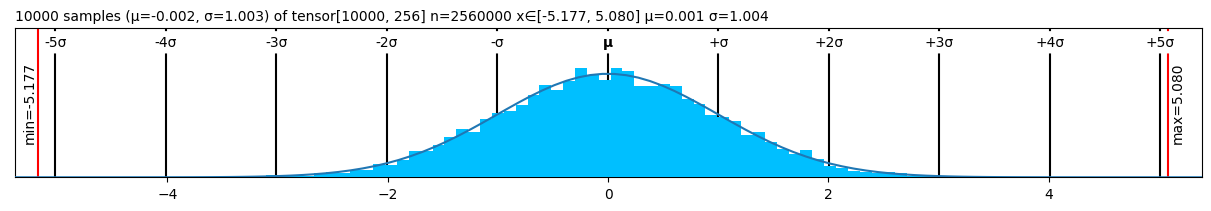

In [3]:
h = 256
x = U(10000, h)
c = (9.04/h)**0.5
w = c*U(h,h)

y = x@w
y.plt

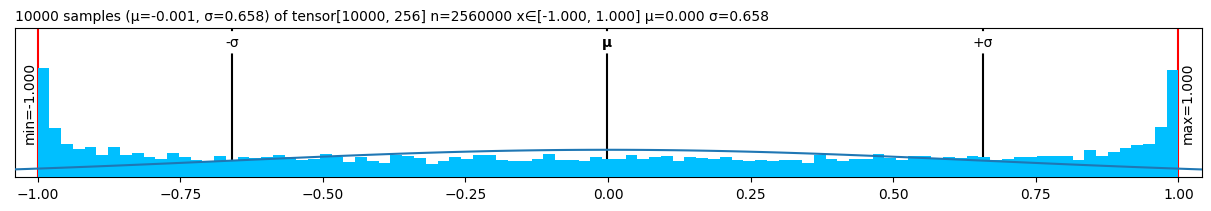

In [4]:
(y.sin()).plt

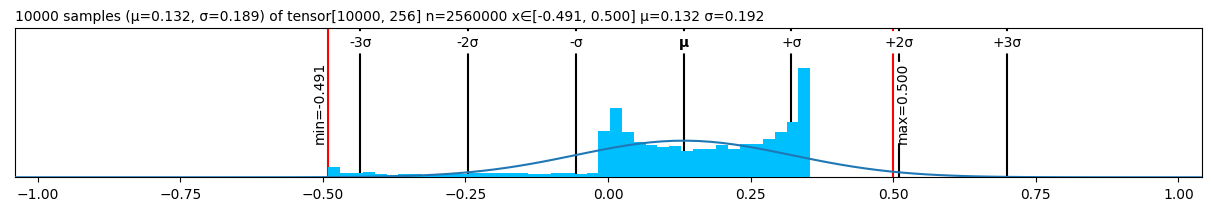

In [5]:
(y.sin() * y.cos() * y.tanh()).plt

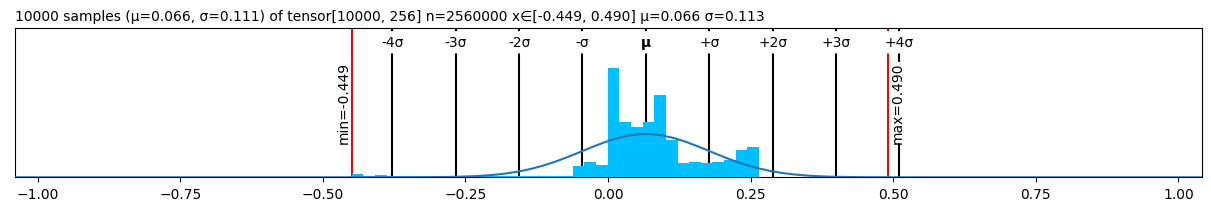

In [6]:
(y.sin() * y.cos() * y.tanh() * y.sigmoid()).plt

In [7]:
# ! pip install geomloss[full]

In [21]:
import torch
from geomloss import SamplesLoss  # See also ImagesLoss, VolumesLoss

# Create some large point clouds in 3D

# Define a Sinkhorn (~Wasserstein) loss between sampled measures
L = SamplesLoss(loss="sinkhorn", p=2, blur=.05)

loss = L(x, y)  # By default, use constant weights = 1/number of samples
g_x, = torch.autograd.grad(loss, [x])  # GeomLoss fully supports autograd!

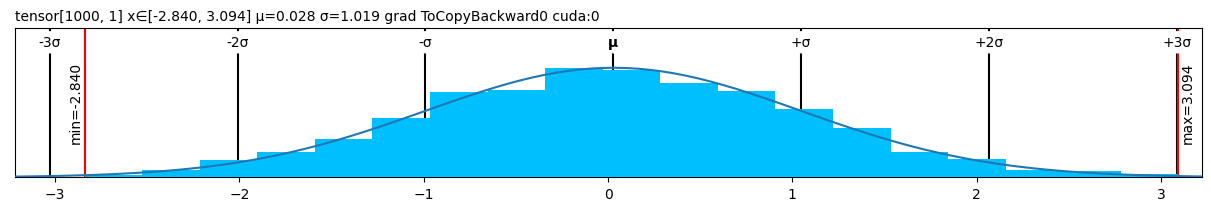

In [23]:
x.plt

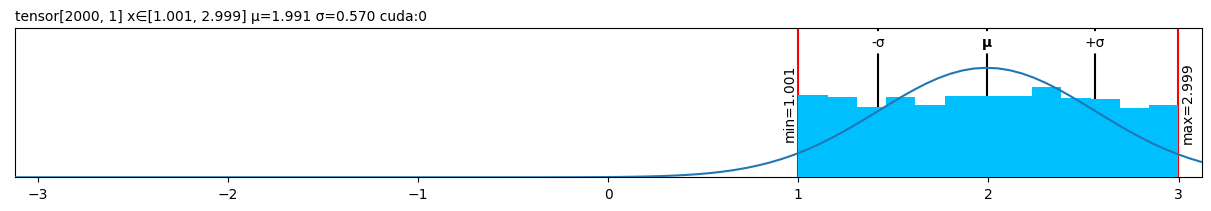

In [19]:
y.plt

In [36]:
lr = 1e1
x = torch.randn(1000, 1, requires_grad=True).cuda()
y = (U(2000, 1) + 2.).cuda()

000 loss=2.023574


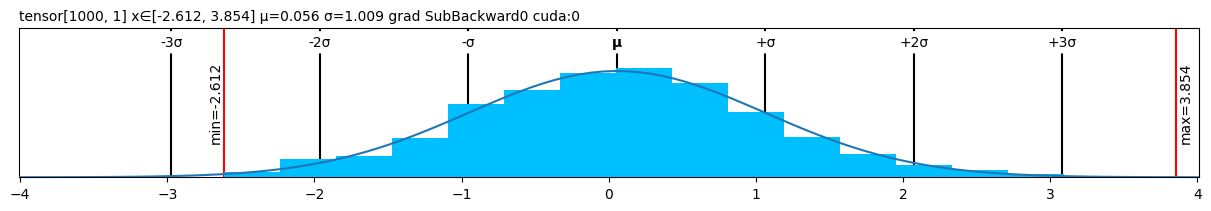

100 loss=0.265582


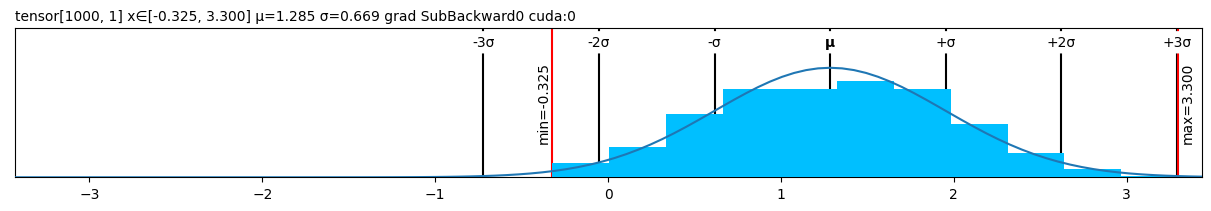

200 loss=0.035305


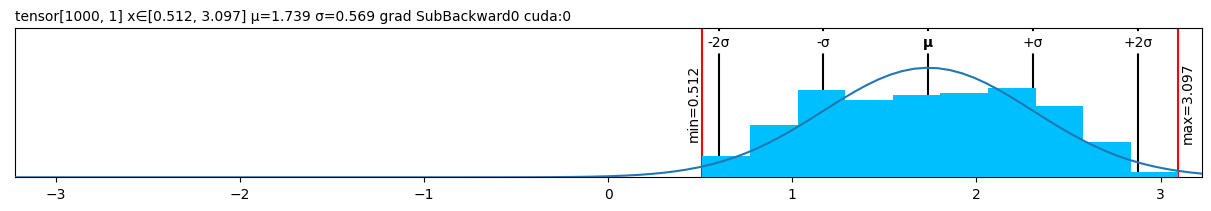

300 loss=0.004926


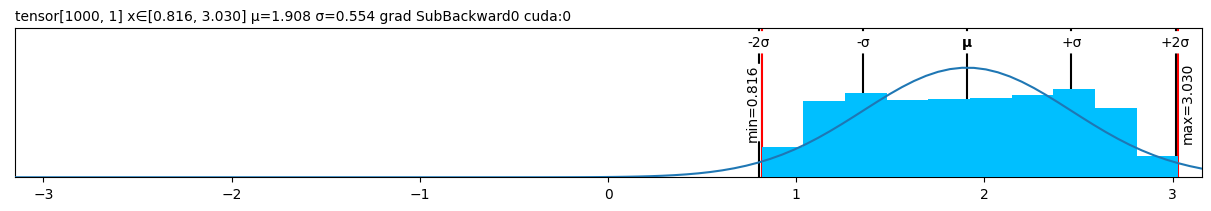

400 loss=0.000729


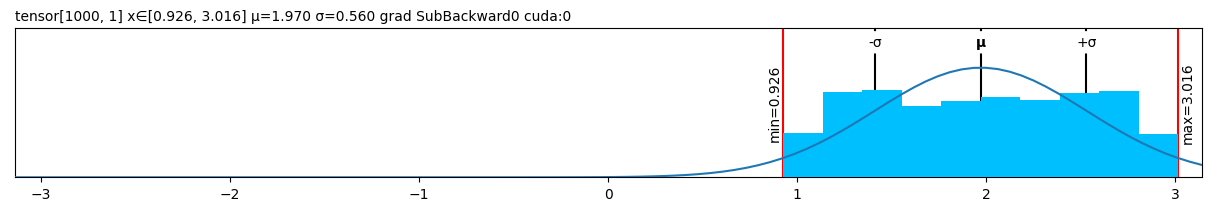

500 loss=0.000113


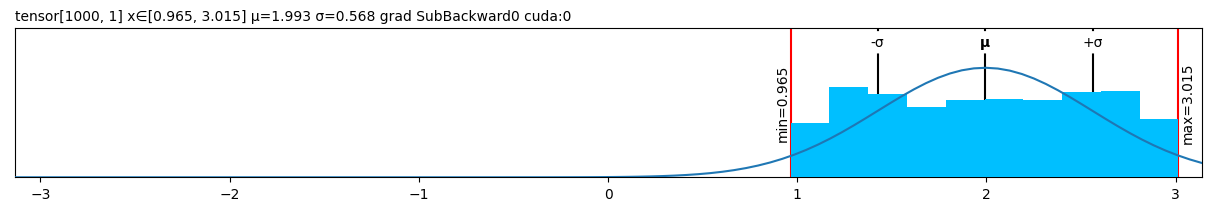

600 loss=0.000020


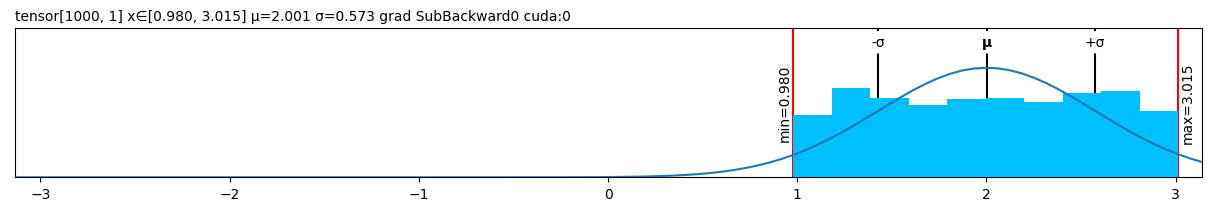

700 loss=0.000007


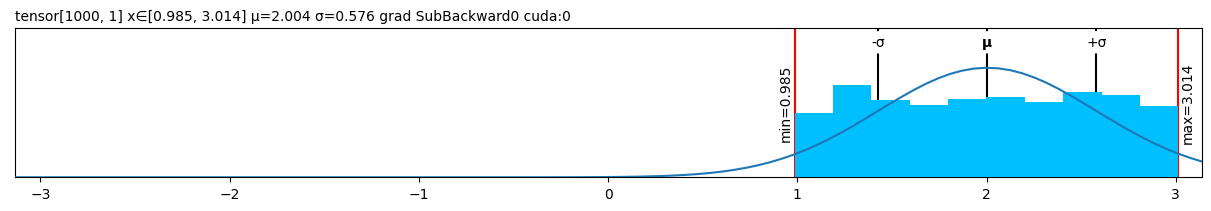

800 loss=0.000005


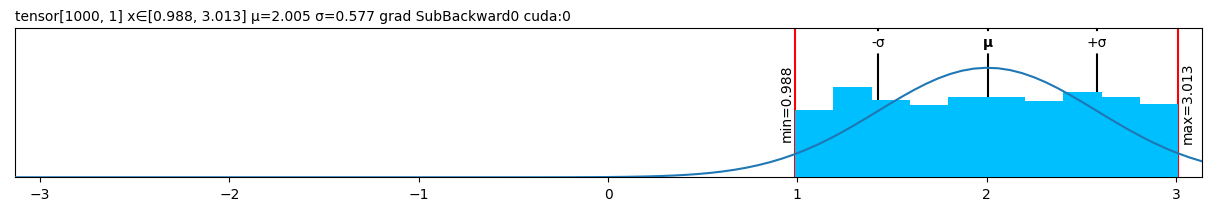

900 loss=0.000003


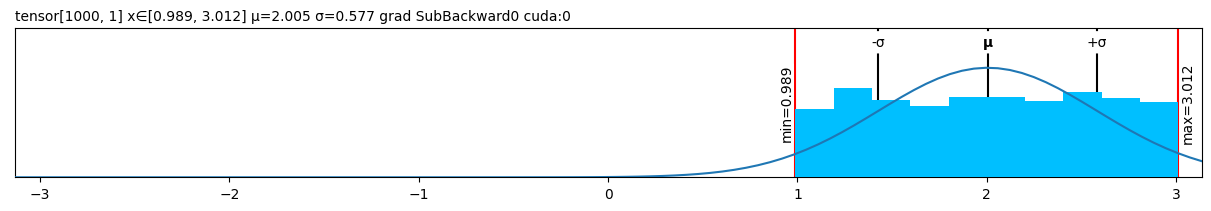

In [37]:
for i in range(1000):
    loss = L(x, y)  # By default, use constant weights = 1/number of samples
    g_x, = torch.autograd.grad(loss, [x])  # GeomLoss fully supports autograd!
    x = x - lr*g_x
    if i % 100 == 0:
        print(f'{i:03} loss={loss.item():.6f}')
        display(x.plt)

In [ ]:
x = torch.randn(1000, 1, requires_grad=True).cuda()
y = (U(2000, 1) + 2.).cuda()

In [ ]:
f

tensor[1000, 1] x∈[-0.004, 0.000] μ=-0.002 σ=0.001 cuda:0

tensor[1000, 1] x∈[-2.840, 3.094] μ=0.028 σ=1.019 grad ToCopyBackward0 cuda:0

In [3]:
g_x

tensor([[ 3.1399e-08, -5.7339e-08, -1.5627e-08],
        [ 3.5264e-07, -1.7823e-07,  1.1114e-06],
        [-3.5234e-08, -1.7188e-07,  2.0468e-07],
        ...,
        [ 1.1362e-07, -1.6981e-07, -4.0952e-07],
        [ 2.1211e-07, -3.7060e-08, -4.7048e-08],
        [ 2.1525e-07,  2.3004e-07,  6.1016e-08]], device='cuda:0')

In [12]:
! pip install POT

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.9/664.9 kB 11.9 MB/s eta 0:00:00 MB/s eta 0:00:01


In [14]:
import torch
import numpy as np
import ot
from ot.pytorch import sinkhorn_divergence

x = torch.randn(1000, 1)
y = torch.rand(256, 1, requires_grad=True)

# Estimate the probability distributions using histograms
hist_x, bin_edges_x = np.histogram(x, bins='auto', density=True)
hist_y, bin_edges_y = np.histogram(y.detach().numpy(), bins='auto', density=True)

# Convert histograms to PyTorch tensors
hist_x = torch.tensor(hist_x, dtype=torch.float, requires_grad=False)
hist_y = torch.tensor(hist_y, dtype=torch.float, requires_grad=True)

# Compute bin centers
bin_centers_x = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])
bin_centers_y = 0.5 * (bin_edges_y[1:] + bin_edges_y[:-1])

# Convert bin centers to PyTorch tensors
bin_centers_x = torch.tensor(bin_centers_x, dtype=torch.float).view(-1, 1)
bin_centers_y = torch.tensor(bin_centers_y, dtype=torch.float).view(-1, 1)

# Set regularization parameter epsilon and the number of iterations
epsilon = 0.01
num_iter = 100

# Compute Sinkhorn divergence
sinkhorn_div = sinkhorn_divergence(hist_x, hist_y, bin_centers_x, bin_centers_y, epsilon, num_iter)

# Use gradient-based optimization to modify y (e.g., using PyTorch's optimizers)


ModuleNotFoundError: No module named 'ot.pytorch'

In [7]:
import torch
import torch.nn as nn

# Adapted from https://github.com/gpeyre/SinkhornAutoDiff
class SinkhornDistance(nn.Module):
    r"""
    Given two empirical measures each with :math:`P_1` locations
    :math:`x\in\mathbb{R}^{D_1}` and :math:`P_2` locations :math:`y\in\mathbb{R}^{D_2}`,
    outputs an approximation of the regularized OT cost for point clouds.

    Args:
        eps (float): regularization coefficient
        max_iter (int): maximum number of Sinkhorn iterations
        reduction (string, optional): Specifies the reduction to apply to the output:
            'none' | 'mean' | 'sum'. 'none': no reduction will be applied,
            'mean': the sum of the output will be divided by the number of
            elements in the output, 'sum': the output will be summed. Default: 'none'

    Shape:
        - Input: :math:`(N, P_1, D_1)`, :math:`(N, P_2, D_2)`
        - Output: :math:`(N)` or :math:`()`, depending on `reduction`
    """
    def __init__(self, eps, max_iter, reduction='none'):
        super(SinkhornDistance, self).__init__()
        self.eps = eps
        self.max_iter = max_iter
        self.reduction = reduction

    def forward(self, x, y):
        # The Sinkhorn algorithm takes as input three variables :
        C = self._cost_matrix(x, y)  # Wasserstein cost function
        x_points = x.shape[-2]
        y_points = y.shape[-2]
        if x.dim() == 2:
            batch_size = 1
        else:
            batch_size = x.shape[0]

        # both marginals are fixed with equal weights
        mu = torch.empty(batch_size, x_points, dtype=torch.float,
                         requires_grad=False).fill_(1.0 / x_points).squeeze()
        nu = torch.empty(batch_size, y_points, dtype=torch.float,
                         requires_grad=False).fill_(1.0 / y_points).squeeze()

        u = torch.zeros_like(mu)
        v = torch.zeros_like(nu)
        # To check if algorithm terminates because of threshold
        # or max iterations reached
        actual_nits = 0
        # Stopping criterion
        thresh = 1e-1

        # Sinkhorn iterations
        for i in range(self.max_iter):
            u1 = u  # useful to check the update
            u = self.eps * (torch.log(mu+1e-8) - torch.logsumexp(self.M(C, u, v), dim=-1)) + u
            v = self.eps * (torch.log(nu+1e-8) - torch.logsumexp(self.M(C, u, v).transpose(-2, -1), dim=-1)) + v
            err = (u - u1).abs().sum(-1).mean()

            actual_nits += 1
            if err.item() < thresh:
                break

        U, V = u, v
        # Transport plan pi = diag(a)*K*diag(b)
        pi = torch.exp(self.M(C, U, V))
        # Sinkhorn distance
        cost = torch.sum(pi * C, dim=(-2, -1))

        if self.reduction == 'mean':
            cost = cost.mean()
        elif self.reduction == 'sum':
            cost = cost.sum()

        return cost, pi, C

    def M(self, C, u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(-1) + v.unsqueeze(-2)) / self.eps

    @staticmethod
    def _cost_matrix(x, y, p=2):
        "Returns the matrix of $|x_i-y_j|^p$."
        x_col = x.unsqueeze(-2)
        y_lin = y.unsqueeze(-3)
        C = torch.sum((torch.abs(x_col - y_lin)) ** p, -1)
        return C

    @staticmethod
    def ave(u, u1, tau):
        "Barycenter subroutine, used by kinetic acceleration through extrapolation."
        return tau * u + (1 - tau) * u1

In [8]:
break

SyntaxError: 'break' outside loop (668683560.py, line 4)

In [9]:
x = U(9,9,9)
y = U(9,9,9)

sinkhorn = SinkhornDistance(eps=0.1, max_iter=100, reduction=None)
dist, P, C = sinkhorn(x, y)
print("Sinkhorn distance: {:.3f}".format(dist.item()))

ValueError: only one element tensors can be converted to Python scalars

In [10]:
dist

tensor[9] x∈[2.797, 4.033] μ=3.463 σ=0.434 [3.035, 3.378, 2.797, 3.299, 3.898, 3.510, 3.224, 4.033, 3.988]

# Sine plot

In [ ]:
h = 256
x = 30.*U(h,h,h)
x.plt

In [ ]:
x.sin().plt

In [ ]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    